# Deep learning models
In the other tutorials, all examples have used scikit-learn models. However,
QSPRpred also has a number of other deep-learning models build-in. These models rely on
torch, therefore you need to make sure to have torch or installed QSPPred with the `deep` (or `full`) option (see [README.txt](https://github.com/CDDLeiden/QSPRpred#readme)).

First, we will load the dataset as usual.

In [17]:
import os
from qsprpred.data.data import QSPRDataset
from qsprpred.data.utils.descriptorsets import FingerprintSet
from qsprpred.data.utils.descriptorcalculator import MoleculeDescriptorsCalculator
from qsprpred.data.utils.datasplitters import RandomSplit

os.makedirs("../../tutorial_output/data", exist_ok=True)

# Create dataset
dataset = QSPRDataset.fromTableFile(
  	filename="../../tutorial_data/A2A_LIGANDS.tsv", 
  	store_dir="../../tutorial_output/data",
  	name="DeepLearningTutorialDataset",
  	target_props=[{"name": "pchembl_value_Mean", "task": "REGRESSION"}],
  	random_state=42
)

# calculate compound features and split dataset into train and test
feature_calculator = MoleculeDescriptorsCalculator(desc_sets = [FingerprintSet(fingerprint_type="MorganFP", radius=3, nBits=2048)])
dataset.prepareDataset(
    split=RandomSplit(test_fraction=0.2, dataset=dataset),
    feature_calculators=[feature_calculator],
    recalculate_features=True,
)

dataset.getDF().head()

,SMILES,pchembl_value_Mean,Year,QSPRID
QSPRID,,,,
DeepLearningTutorialDataset_0,Cc1cc(C)n(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n...,8.68,2008.0,DeepLearningTutorialDataset_0
DeepLearningTutorialDataset_1,Nc1c(C(=O)Nc2ccc([N+](=O)[O-])cc2)sc2nc3c(cc12...,4.82,2010.0,DeepLearningTutorialDataset_1
DeepLearningTutorialDataset_2,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,5.65,2009.0,DeepLearningTutorialDataset_2
DeepLearningTutorialDataset_3,CNC(=O)C12CC1C(n1cnc3c(NCc4cccc(Cl)c4)nc(C#CCC...,5.45,2009.0,DeepLearningTutorialDataset_3
DeepLearningTutorialDataset_4,CCCn1c(=O)c2c(nc3cc(OC)ccn32)n(CCCNC(=O)c2ccc(...,5.20,2019.0,DeepLearningTutorialDataset_4


## Fully connected neural network
### Initialization
The first model we will look at is a fully connected neural network. This model uses the `DDNModel` class instead of the `SklearnModel` class. The `DDNModel` class accepts a `patience` argument, which is the number of epochs to wait before stopping training if the validation loss does not improve and a tolerance ( `tol`) argument, which is the minimum improvement in validation loss to be considered an improvement.

Other parameters for the underlying estimator `STFullyConnected` can be passed to the `parameters` argument as usual.
There is no need to specify the `alg` argument, as currently only `STFullyConnected` is available.

In [18]:
# Create model
from qsprpred.extra.gpu.models.dnn import DNNModel

os.makedirs("../../tutorial_output/models", exist_ok=True)
model = DNNModel(
    base_dir = '../../tutorial_output/models',
    data = dataset,
    name = 'DeepLearningTutorialModel',
    parameters={'n_epochs': 100}, # maximum number of epochs to train for
    patience=3,
    tol=0.01,
    random_state=42
)

### Early Stopping
The `DNNModel` supports early stopping of the training, which as mentioned can be controlled by the `patience` and the `tol` arguments. You can check if a model supports early stopping, by checking the `supportsEarlyStopping` attribute.

In [19]:
model.supportsEarlyStopping

True

The model can be trained as usual, but a part of the training set will be used as a validation set to determine wether to stop training. By default a random 10% of the training set is used as a validation set. This can be changed by setting the `split` argument of `QSPRModel.fit` to a different value, which can be any scikit-learn or QSPRPred `DataSplit`. See the [data splitting tutorial](../../basics/data/data_splitting.ipynb) for more information on the possibilities. Here, you can see how to change the validation split to a 20% random split.

In [20]:
from qsprpred.models.assessment_methods import CrossValAssessor
from qsprpred.models.early_stopping import EarlyStoppingMode
from qsprpred.models.metrics import SklearnMetric

CrossValAssessor(SklearnMetric.getMetric(name='r2'))(model, split=RandomSplit(test_fraction=0.2, dataset=dataset))

[-1.5856398456113023,
 -1.6129529933116973,
 -1.7590960006101684,
 -2.0787720325773518,
 -1.3843458033992104]

If a model supports early stopping, it also has an `EarlyStopping` attribute which is an instance of the `EarlyStopping` class that keeps track of the number of epochs trained. The `EarlyStopping` class has a `mode` attribute that sets how early stopping should be handled when fitting the estimator. It can be one of four modes: `EarlyStoppingMode.RECORDING`, `EarlyStoppingMode.NOT_RECORDING`, `EarlyStoppingMode.OPTIMAL`, `EarlyStoppingMode.FIXED`. You can find [a schematic overview](####early-stopping-modes-overview) of the different modes below.
By default it is set to `EarlyStoppingMode.NOT_RECORDING`.

In [21]:
model.earlyStopping.mode

<EarlyStoppingMode.NOT_RECORDING: 'NOT_RECORDING'>

In this mode (`EarlyStoppingMode.NOT_RECORDING`), the `EarlyStopping` class will not keep track of at which epoch the training is stopped in a fit. In the `EarlyStoppingMode.RECORDING` mode the `EarlyStopping` class will keep track of the epoch on which the training was stopped. This can be accessed through the `EarlyStopping` class `trainedEpochs` attribute, which is a list of the epochs on which the training was stopped. You can see that for now it is just an empty list.

In [22]:
model.earlyStopping.trainedEpochs

[]

If we then run a cross-validation with the mode set to `EarlyStoppingMode.RECORDING`, we can see that the `trainedEpochs` attribute is now filled with the epochs on which the training was stopped for each fold.

In [23]:
from qsprpred.models.assessment_methods import CrossValAssessor
from qsprpred.models.early_stopping import EarlyStoppingMode
from qsprpred.models.metrics import SklearnMetric

CrossValAssessor(SklearnMetric.getMetric(name='r2'), mode=EarlyStoppingMode.RECORDING)(model)
model.earlyStopping.trainedEpochs

[61, 51, 63, 34, 55]

Mind that the mode has now been changed to `EarlyStoppingMode.RECORDING`, therefore, if you run the cross-validation again, the `trainedEpochs` attribute will be appended with the epochs on which the training was stopped previously.

In [24]:
model.earlyStopping.mode

<EarlyStoppingMode.RECORDING: 'RECORDING'>

In [25]:
CrossValAssessor(SklearnMetric.getMetric(name='r2'))(model)
model.earlyStopping.trainedEpochs

[61, 51, 63, 34, 55, 63, 51, 62, 34, 56]

The `EarlyStopping` class has an attribute `optimalEpochs`, which is an aggregation of the `trainedEpochs` attribute, calculated by the `aggregateFunc`, which by default is the arithmetric mean. You can change the `aggregateFunc` by passing a function to the `aggregateFunc` argument of the `EarlyStopping` class. For example, if you want to use the median instead of the mean, you can pass the `np.median` function to the `aggregateFunc` argument.

In [26]:
model.earlyStopping.aggregateFunc

<function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>, *, where=<no value>)>

In [27]:
model.earlyStopping.optimalEpochs

53

In [28]:
import numpy as np
model.earlyStopping.aggregateFunc = np.median
model.earlyStopping.optimalEpochs

56

If we now fit the model with the `EarlyStoppingMode.OPTIMAL` mode, the estimator will be fitted for exactly `optimalEpochs`. This is the `EarlyStoppingMode` that is used by default for `QSPRModel.fitAttached`. This is done to avoid having to use a part of the dataset as validation set to determine the early stopping epoch in the final fit of the model. However, if you want to use a different mode, you can pass it to the `mode` argument of the `QSPRModel.fitAttached` method.

In [29]:
model.fitAttached()

'../../tutorial_output/models/DeepLearningTutorialModel/DeepLearningTutorialModel_meta.json'

We can also reset the recorded epochs with the `clean` function. If we then try to run fit attached with the `EarlyStoppingMode.OPTIMAL` mode, we get an error, because the `trainedEpochs` attribute is empty.

In [30]:
model.earlyStopping.clean()
print(model.earlyStopping.trainedEpochs)
try:
    model.fitAttached()
except ValueError as e:
    print(e)

[]
No number of epochs have been recorded yet, first run fit with early stopping mode set to RECORDING or set the optimal number of epochs manually.


Another option is to forgo early stopping and just train for a fixed number of epochs. This can be done by setting the `mode` argument to `EarlyStoppingMode.FIXED` and `QSPRModel.earlyStopping.numEpochs` argument to the number of epochs to train for.
Be aware, that if you `DNNModel` parameter `n_epochs` is set to a value smaller than `QSPRModel.earlyStopping.numEpochs`, the model will only be trained for `n_epochs` epochs, as this is the maximum number of epochs to train for.
In this example, we will train the model for 10 epochs.

In [31]:
model.earlyStopping.numEpochs = 10
model.fitAttached(mode=EarlyStoppingMode.FIXED)

'../../tutorial_output/models/DeepLearningTutorialModel/DeepLearningTutorialModel_meta.json'

#### Early stopping modes overview
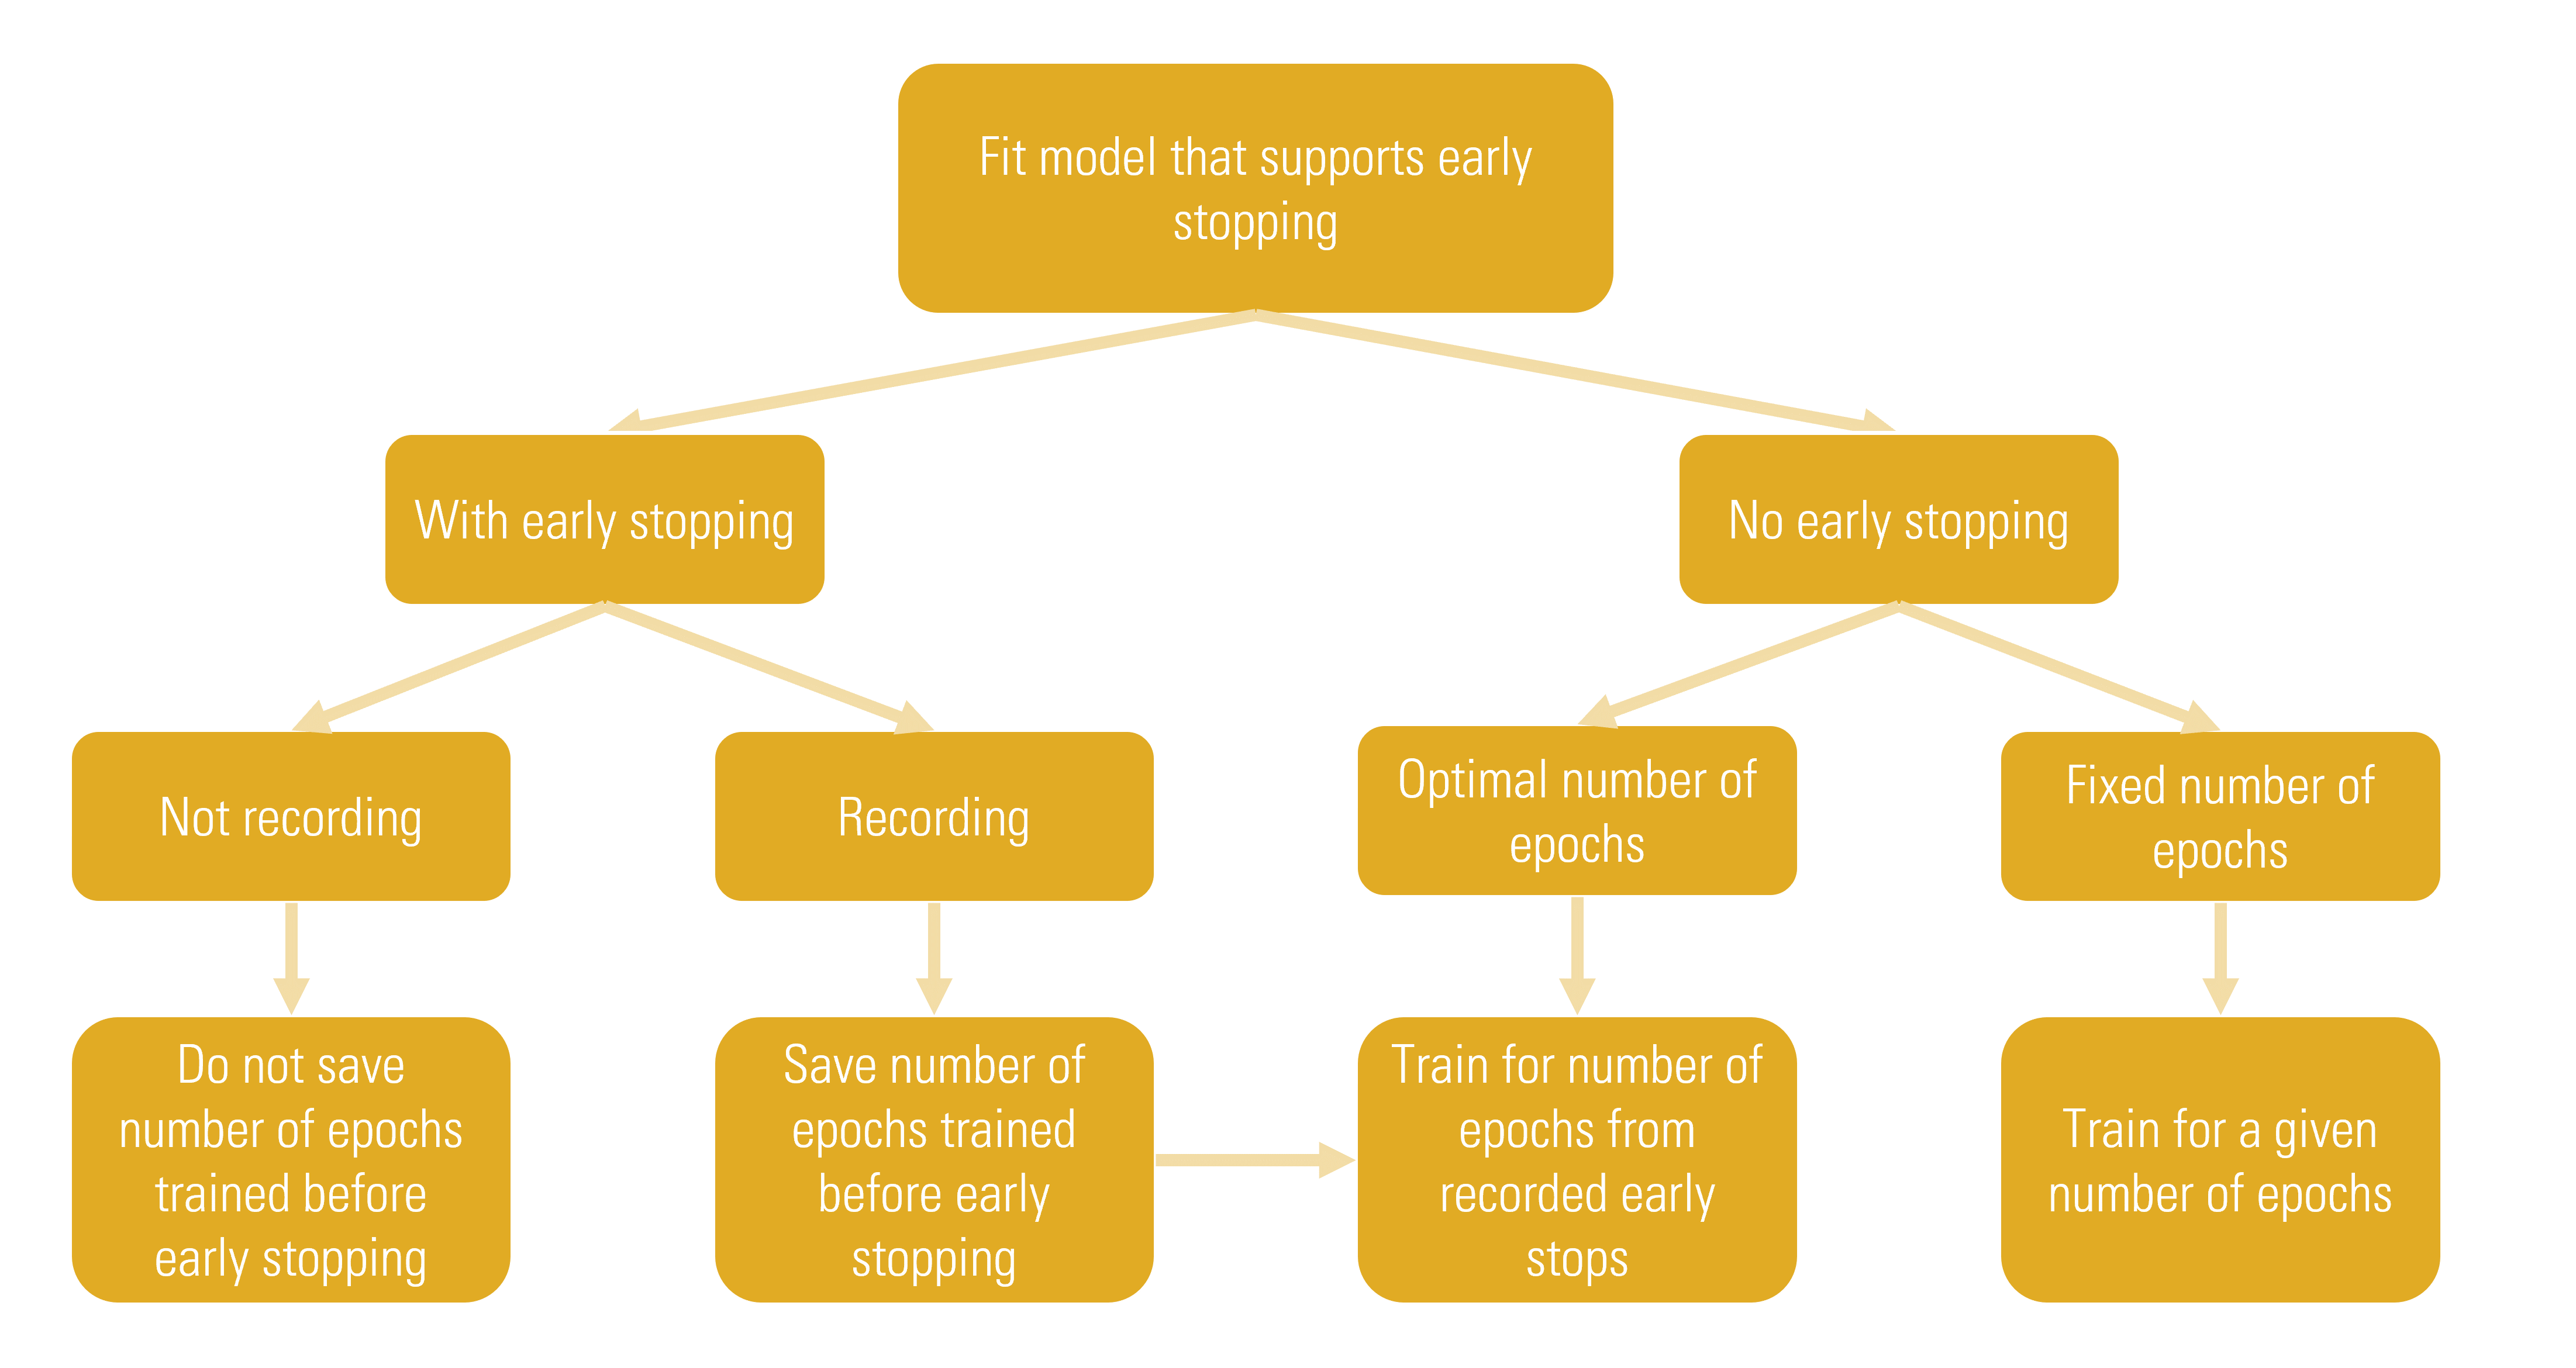

### Training
Below we will train show a complete training of the DNN. First we run hyperparameter optimization to find the best parameters for the model. Here we will will use `EarlyStoppingMode.NOT_RECORDING` as the best epoch to stop training may depend on the hyper-parameters. Then we will apply cross-validation and test set evaluation to get an estimate of the performance of the model, with early stopping set to `EarlyStoppingMode.RECORDING`. Finally, we will use `QSPRModel.fitAttached` training for exactly the average number of epochs trained for in the cross-validation and the test set evaluation.

In [32]:
from qsprpred.models.hyperparam_optimization import GridSearchOptimization
from qsprpred.models.assessment_methods import CrossValAssessor, TestSetAssessor
from qsprpred.models.metrics import SklearnMetric
from qsprpred.models.early_stopping import EarlyStoppingMode

score_func = SklearnMetric.getMetric(name='r2')

# Define the search space
search_space = {"lr": [1e-4, 1e-3,], "neurons_h1" : [100, 200]}

gridsearcher = GridSearchOptimization(
    param_grid=search_space,
    model_assessor=TestSetAssessor(
        scoring=SklearnMetric.getDefaultMetric(model.task),
        mode=EarlyStoppingMode.NOT_RECORDING
    ),
)
gridsearcher.optimize(model)

# Create a CrossValAssessor object
CrossValAssessor(score_func, mode=EarlyStoppingMode.RECORDING)(model)
TestSetAssessor(score_func, mode=EarlyStoppingMode.RECORDING)(model)

model.earlyStopping.aggregateFunc = np.mean
print(model.earlyStopping.trainedEpochs) # list of 6 values, one for each cross-validation fold and one for the test set
print(model.earlyStopping.optimalEpochs) # average of the 6 values

# fit the model on the whole dataset
model.fitAttached(mode=EarlyStoppingMode.OPTIMAL)

[19, 15, 21, 24, 27, 25]
22


'../../tutorial_output/models/DeepLearningTutorialModel/DeepLearningTutorialModel_meta.json'